# 

## Install Python libraries
* To temporarily install Python libraries for server use, use the command: `%pip`.

In [14]:
%%time
%pip install simplekml
%pip install geopy
%pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
CPU times: user 111 ms, sys: 122 ms, total: 233 ms
Wall time: 13.3 s


# Python libraries

In [15]:
%%time
from sliderule import sliderule, icesat2,earthdata
import geopandas as gpd
import pandas as pd
import folium
import numpy as np
from shapely.geometry import Polygon, Point, mapping
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.linear_model import LinearRegression
import geopy
import simplekml
from geopy.distance import geodesic
from matplotlib.backends.backend_pdf import PdfPages
import plotly.express as px

CPU times: user 103 µs, sys: 0 ns, total: 103 µs
Wall time: 105 µs


# Define the Region:
define the region using the toregion function, which converts the GeoJSON file into a format recognized by SlideRule.

In [16]:
%%time

years = [2019, 2020, 2021, 2022, 2023]
segment_meter = "100"
cnt = "10"
ats = "10"

# site_name = "BONA"
# site_name = "DEJU"
# site_name = "WREF"
# site_name = "RMNP"
site_name = "TEAK"

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 13.4 µs


# Set Parameters:

In [17]:
%%time
# Time Parameter
#! relevant dates:  2021-03-22, 2022-12-18, 2019-12-24

def generate_year_time_ranges(years):
    """
    Generate a dictionary of start and end times for each specified year.

    Args:
        years (list of int): List of years for which to generate time ranges.
        
    Returns:
        dict: A dictionary where the keys are years, and the values are dictionaries
              with 'start_time' and 'end_time'.
    """
    time_ranges = {}
    for year in years:
        start_time = f"{year}-01-01T00:00:00Z"
        end_time = f"{year}-12-31T23:59:59Z"
        time_ranges[year] = {"start_time": start_time, "end_time": end_time}
    return time_ranges

site_time_ranges = generate_year_time_ranges(years)

print(site_time_ranges)


{2019: {'start_time': '2019-01-01T00:00:00Z', 'end_time': '2019-12-31T23:59:59Z'}, 2020: {'start_time': '2020-01-01T00:00:00Z', 'end_time': '2020-12-31T23:59:59Z'}, 2021: {'start_time': '2021-01-01T00:00:00Z', 'end_time': '2021-12-31T23:59:59Z'}, 2022: {'start_time': '2022-01-01T00:00:00Z', 'end_time': '2022-12-31T23:59:59Z'}, 2023: {'start_time': '2023-01-01T00:00:00Z', 'end_time': '2023-12-31T23:59:59Z'}}
CPU times: user 95 µs, sys: 0 ns, total: 95 µs
Wall time: 82.5 µs


# Build ATL03 Request Parameters:

Construct a dictionary of parameters to specify how the ATL03 data should be processed.

In [18]:
%%time

def process_site(site, time_ranges):
    """
    Processes a site by requesting ATL03 data for specified time ranges.

    Args:
        region (dict): A dictionary containing the spatial region of interest, with a 'poly' key for the polygon.
        time_ranges (dict): A dictionary where keys are years, and values are dictionaries with 'start_time' and 'end_time'.
        cnt (int, optional): Number of photons required for the analysis. Defaults to None.
        ats (int, optional): Along-track spacing for the data. Defaults to None.
        segment_meter (float, optional): Segment length and resolution in meters. Defaults to 10.

    Returns:
        dict: A dictionary where keys are years, and values are the retrieved ATL03 data.
    """
    # Load the region dynamically based on the site
    region = sliderule.toregion(f"geojson_files/{site}_buffer_8km.geojson")
    
    # Dictionary to store ATL03 data for each year
    site_data = {}
    
    for year, times in time_ranges.items():
        # Construct the parameters for the current time range
        parms = {
            "poly": region['poly'],       # Region polygon
            "t0": times['start_time'],   # Start time
            "t1": times['end_time'],     # End time
            "srt": icesat2.SRT_LAND,           # Surface return type
            "cnf": 0,                    # Confidence level
            "cnt": cnt,                  # Number of photons
            "ats": ats,                  # Along-track spacing
            "len": segment_meter,        # Segment length
            "res": segment_meter,        # Resolution
            "atl08_class": [             # ATL08 classifications
                "atl08_noise",
                "atl08_ground",
                "atl08_canopy",
                "atl08_top_of_canopy",
                "atl08_unclassified"
            ],
            "phoreal": {                 # Phoreal processing settings
                "binsize": 1.0,
                "geoloc": "mean",
                "use_abs_h": True,
                "send_waveform": True
            }
        }
        
        # Request the ATL03 data using icesat2
        atl03_data = icesat2.atl03sp(parms, keep_id=True)

        columns_to_drop = [
        'region', 'pair', 'segment_dist', 'segment_id', 'cycle', 'track', 'background_rate', 'y_atc', 'x_atc', 
            'yapc_score', 'atl03_cnf', 'relief', 'quality_ph'
        ]
        
        # Drop the columns from the DataFrame
        atl03_data = atl03_data.drop(columns=columns_to_drop)
        site_data[year] = atl03_data

    return site_data

site_data = process_site(site_name, site_time_ranges)

Exception <-1>: Failure on resource ATL03_20190313161135_11490202_006_02.h5 track 2.1: H5Coro::Future read failure on /gt2r/signal_photons/ph_segment_id
Exception <-1>: Failure on resource ATL03_20190313161135_11490202_006_02.h5 track 3.1: H5Coro::Future read failure on /gt3r/signal_photons/ph_segment_id
Exception <-1>: Failure on resource ATL03_20190313161135_11490202_006_02.h5 track 2.0: H5Coro::Future read failure on /gt2l/signal_photons/ph_segment_id
Exception <-1>: Failure on resource ATL03_20190313161135_11490202_006_02.h5 track 3.0: H5Coro::Future read failure on /gt3l/signal_photons/ph_segment_id
Exception <-1>: Failure on resource ATL03_20230228071257_10651806_006_02.h5 track 3.1: H5Coro::Future read failure on /gt3r/signal_photons/ph_segment_id
Exception <-1>: Failure on resource ATL03_20230228071257_10651806_006_02.h5 track 2.1: H5Coro::Future read failure on /gt2r/signal_photons/ph_segment_id
Exception <-1>: Failure on resource ATL03_20230228071257_10651806_006_02.h5 track 

CPU times: user 1min 24s, sys: 2.39 s, total: 1min 27s
Wall time: 1min 40s


# Retrieve ATL03 Data:
Use the atl03sp function to retrieve the ATL03 data based on the specified parameters.

In [19]:
%%time

for year, site_datum in site_data.items():
    print(f"year: {year}")
    print(site_datum.columns)
    print(f"length: {len(site_datum)}")

year: 2019
Index(['extent_id', 'sc_orient', 'solar_elevation', 'rgt', 'height',
       'atl08_class', 'landcover', 'snowcover', 'geometry', 'spot'],
      dtype='object')
length: 610744
year: 2020
Index(['extent_id', 'sc_orient', 'solar_elevation', 'rgt', 'height',
       'atl08_class', 'landcover', 'snowcover', 'geometry', 'spot'],
      dtype='object')
length: 242020
year: 2021
Index(['extent_id', 'sc_orient', 'solar_elevation', 'rgt', 'height',
       'atl08_class', 'landcover', 'snowcover', 'geometry', 'spot'],
      dtype='object')
length: 703305
year: 2022
Index(['extent_id', 'sc_orient', 'solar_elevation', 'rgt', 'height',
       'atl08_class', 'landcover', 'snowcover', 'geometry', 'spot'],
      dtype='object')
length: 1155792
year: 2023
Index(['extent_id', 'sc_orient', 'solar_elevation', 'rgt', 'height',
       'atl08_class', 'landcover', 'snowcover', 'geometry', 'spot'],
      dtype='object')
length: 1456274
CPU times: user 5.38 ms, sys: 1.94 ms, total: 7.32 ms
Wall time: 7.1

In [20]:
%%time

def process_photons(site_data):
    """
    Processes site data to calculate canopy and terrain photon rates for each segment and checks for duplicate times.

    Args:
        site_data (dict): A dictionary where each value is a DataFrame containing data for a site.

    Returns:
        dict: A dictionary with the same keys as `site_data`, containing processed DataFrames.
    """
    processed_data = {}

    for year, data in site_data.items():
        # Ensure 'time' is the index and in datetime format
        data.index = pd.to_datetime(data.index)

        # Extract latitude and longitude from the 'geometry' column
        data['latitude'] = data['geometry'].apply(lambda x: x.y if x else None)
        data['longitude'] = data['geometry'].apply(lambda x: x.x if x else None)

        # Separate photons into canopy and terrain classes
        canopy_photons = data[data['atl08_class'].isin([2, 3])]  # Classes 2 and 3 for canopy
        terrain_photons = data[data['atl08_class'] == 1]         # Class 1 for ground

        # Count photons for each segment
        canopy_counts = canopy_photons.groupby('extent_id').size().reset_index(name='canopy_photon_count')
        terrain_counts = terrain_photons.groupby('extent_id').size().reset_index(name='terrain_photon_count')

        # Convert the index to a column temporarily
        data['time_index'] = data.index
        
        # Group by 'extent_id' and count unique 'time_index' values (representing unique times)
        unique_time_count = (
            data.groupby('extent_id')['time_index']
            .nunique()
            .reset_index(name='unique_shots')
        )
        
        # Drop the temporary 'time_index' column
        data = data.drop(columns='time_index')

        # Merge canopy and terrain counts into one DataFrame
        segment_counts = (
            canopy_counts
            .merge(terrain_counts, on='extent_id', how='outer')
            .merge(unique_time_count, on='extent_id', how='outer')
        )

        # Replace any zero or NaN values in 'unique_shots' with NaN to avoid division by zero errors
        segment_counts['unique_shots'] = segment_counts['unique_shots'].replace(0, np.nan)

        # Calculate photon rates by normalizing with the number of unique shots
        segment_counts['canopy_photon_rate'] = segment_counts['canopy_photon_count'] / segment_counts['unique_shots']
        segment_counts['terrain_photon_rate'] = segment_counts['terrain_photon_count'] / segment_counts['unique_shots']

        # Reset index to keep 'time' as a column for merging
        data = data.reset_index()

        # Merge photon rates into the main DataFrame
        data = data.merge(
            segment_counts[['extent_id', 'canopy_photon_rate', 'terrain_photon_rate']], 
            on='extent_id', how='left'
        )

        # Check for duplicates in the 'time' column
        duplicate_times = data[data.index.duplicated()]

        # Log duplicates if needed (optional)
        if not duplicate_times.empty:
            print(f"Year {year}: Found duplicate times in the 'time' column.")

        # Store processed data
        processed_data[year] = data

    return processed_data

processed_site_data = process_photons(site_data)

CPU times: user 1min 35s, sys: 961 ms, total: 1min 36s
Wall time: 1min 35s


In [21]:
# Adjust display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Use full width of the terminal
pd.set_option('display.expand_frame_repr', False)  # Avoid column wrapping

# Group by 'extent_id' and 'spot', then get the first row for each unique combination
unique_spot_rows = processed_site_data[2023].drop_duplicates(subset=['extent_id', 'spot'])

# Display the result
print(len(unique_spot_rows))
# unique_spot_rows.head(50)
print(unique_spot_rows.head())
del unique_spot_rows

933
                               time            extent_id  sc_orient  solar_elevation   rgt       height  atl08_class  landcover  snowcover                     geometry  spot   latitude   longitude  canopy_photon_rate  terrain_photon_rate
0     2023-03-05 18:51:24.957660672  5174637219536699404          0        43.569527  1149  2175.964844            4        255        255  POINT (-119.01994 36.97277)     3  36.972774 -119.019935                 NaN                  NaN
3890  2023-03-05 18:51:24.965460480  5174637219536699408          0        43.568699  1149  1748.194458            4        255        255  POINT (-119.01999 36.97329)     3  36.973287 -119.019989                 NaN                  NaN
11189 2023-03-05 18:51:24.979360512  5174637219536699412          0        43.567886  1149  1351.081055            4        255        255  POINT (-119.02008 36.97419)     3  36.974186 -119.020084                 NaN                  NaN
19171 2023-03-05 18:51:24.997660672  5174637

# Data processing on ATL03 photon data
* extracting coordinates, separating photon classes, and counting canopy and terrain photons by segment.

### Landcover Assignment
Calculate the mode (most frequent value) of landcover per `extent_id`, while handling missing or invalid values.

In [22]:
%%time
def add_landcover_and_date_info(processed_site_data):
    """
    Adds landcover mode and date-related columns (month, year, day) to each site DataFrame in processed_site_data.

    Args:
        processed_site_data (dict): A dictionary where each value is a DataFrame containing data for a site.

    Returns:
        dict: A dictionary with the same keys as `processed_site_data`, containing updated DataFrames.
    """
    valid_landcover_codes = {111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20}

    updated_data = {}

    for year, data in processed_site_data.items():
        # Step 1: Ensure there are no invalid landcover values before grouping
        valid_landcover_data = data[data["landcover"].isin(valid_landcover_codes)].copy()

        # Step 2: Calculate the landcover mode for each extent_id
        landcover_modes = valid_landcover_data.groupby("extent_id")["landcover"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

        # Step 3: Assign the calculated mode back to the original DataFrame
        data["landcover_mode"] = data["extent_id"].map(landcover_modes)

        # Step 4: Set 'time' back as the index if not already
        if "time" in data.columns:
            data.set_index("time", inplace=True)
            data.index = pd.to_datetime(data.index)

        # Step 5: Extract month, year, and day for aggregation
        data["month"] = data.index.month
        data["year"] = data.index.year
        data["day"] = data.index.day

        # Store the updated DataFrame in the dictionary
        updated_data[year] = data

    return updated_data

processed_site_data = add_landcover_and_date_info(processed_site_data)

CPU times: user 1.95 s, sys: 3.48 ms, total: 1.95 s
Wall time: 1.95 s


In [23]:
# Adjust display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Use full width of the terminal
pd.set_option('display.expand_frame_repr', False)  # Avoid column wrapping

# Group by 'extent_id' and 'spot', then get the first row for each unique combination
unique_spot_rows = processed_site_data[2021].drop_duplicates(subset=['extent_id', 'spot'])

# Display the result
print(len(unique_spot_rows))
# unique_spot_rows.head(50)
print(unique_spot_rows.head(50))
del unique_spot_rows

798
                                         extent_id  sc_orient  solar_elevation   rgt       height  atl08_class  landcover  snowcover                     geometry  spot   latitude   longitude  canopy_photon_rate  terrain_photon_rate  landcover_mode  month  year  day
time                                                                                                                                                                                                                                                                     
2021-03-03 17:59:56.565298688  4796334317187891288          1        37.197472  1065  2190.787842            4        255        255  POINT (-119.02022 37.02178)     6  37.021782 -119.020225                 NaN                  NaN             NaN      3  2021    3
2021-03-03 17:59:56.575698688  4796334317187891292          1        37.198238  1065  1302.017700            4        255        255   POINT (-119.02041 37.0211)     6  37.021100 -119.020409        

## Photon and Segment Counts by Date

In [24]:
%%time
def output_photon_counts_by_day(processed_site_data, output_dir):
    """
    Outputs photon counts by day for each site, separated by ATL08 categories, into CSV files.

    Args:
        processed_site_data (dict): A dictionary where each value is a DataFrame containing processed data for a site.
        output_dir (str): The directory where the CSV files should be saved.
        site_name (str): The name of the site (used for output file naming).
        ats (str): The ATS value (used for output file naming).

    Returns:
        None
    """
    # Define ATL08 classification categories and their values
    atl08_categories = {
        "unclassified": 0,
        "ground": 1,
        "canopy": 2,
        "top_of_canopy": 3,
        "noise": 4
    }

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for year, data in processed_site_data.items():
        # Ensure 'time' is in datetime format and extract the date part
        data['date'] = data.index.date

        # Create a dictionary to hold count DataFrames for each category
        category_counts = {}

        # Count photons for each ATL08 category
        for category, value in atl08_categories.items():
            category_counts[category] = (data[data['atl08_class'] == value].groupby('date').size().reset_index(name=f"{category}_photon_count"))

        # Count unique segments (extent_id) for each date
        segment_counts_by_date = (data.groupby('date')['extent_id'].nunique().reset_index(name="segment_count"))

        # Start with the segment counts
        counts_by_date = segment_counts_by_date

        # Merge counts for each ATL08 category
        for category, count_df in category_counts.items():
            counts_by_date = counts_by_date.merge(count_df, on="date", how="outer")

        # Fill NaN values with 0 for days where no photons are present in a category
        counts_by_date.fillna(0, inplace=True)

        # Create a file name based on the specified format
        savefile = os.path.join(output_dir, f'{site_name}_terrain_vs_canopy_{year}_ats{ats}.csv')

        # Save the aggregated data to a CSV file
        counts_by_date.to_csv(savefile, index=False)
        print(f"Saved photon counts for {year} to {savefile}")

folder = 'year/'
output_photon_counts_by_day(processed_site_data, folder)

Saved photon counts for 2019 to year/TEAK_terrain_vs_canopy_2019_ats10.csv
Saved photon counts for 2020 to year/TEAK_terrain_vs_canopy_2020_ats10.csv
Saved photon counts for 2021 to year/TEAK_terrain_vs_canopy_2021_ats10.csv
Saved photon counts for 2022 to year/TEAK_terrain_vs_canopy_2022_ats10.csv
Saved photon counts for 2023 to year/TEAK_terrain_vs_canopy_2023_ats10.csv
CPU times: user 2.32 s, sys: 15.5 ms, total: 2.33 s
Wall time: 2.38 s


# DATA Visualization

### All Months Scatter Plots of Terrain Photon Rate vs. Canopy Photon

Superplot saved as year/RMNP_strong_vs_weak_beams_2023_ats10.png


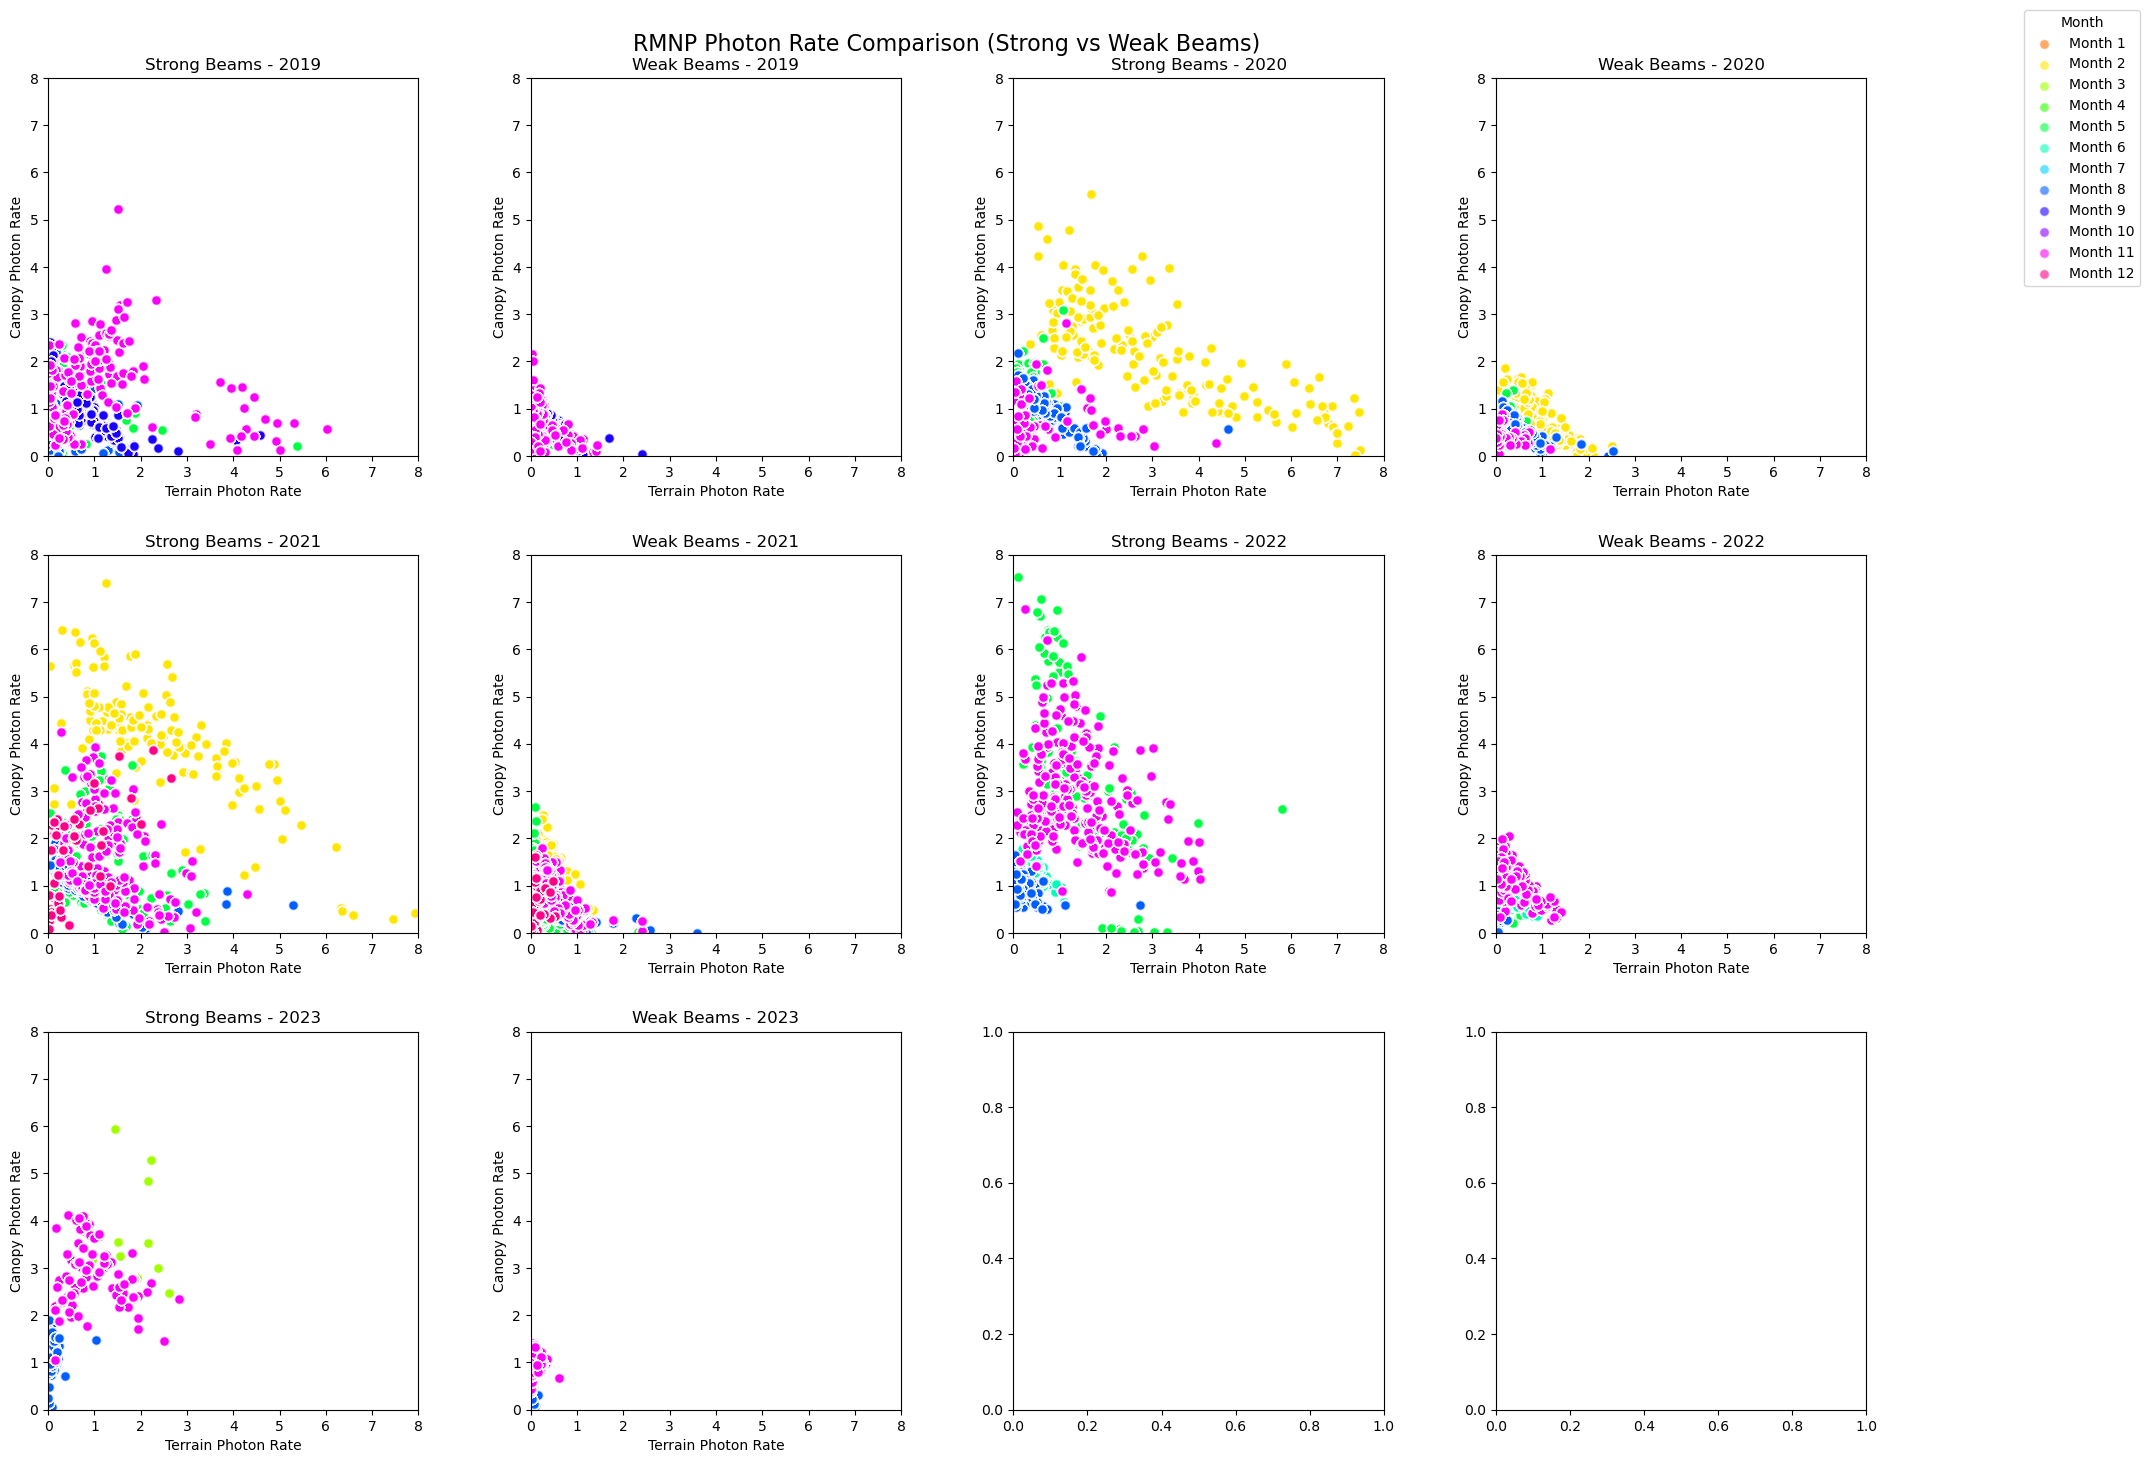

CPU times: user 1min 22s, sys: 439 ms, total: 1min 22s
Wall time: 1min 22s


In [12]:
%%time

def plot_site_photon_rate(year, data, beam_type, ax):
    """
    Create a scatter plot for photon rates for strong or weak beams for a given year.

    Args:
        year (int): The year for which the plot is being generated.
        data (DataFrame): The data for the site.
        beam_type (str): Either 'strong' or 'weak' to specify which beam to plot.
        ax (matplotlib axis): The axis object for the subplot.

    Returns:
        None
    """
    # Filter data based on the beam type
    beam_filter = data['spot'].isin([1, 3, 5]) if beam_type == 'strong' else data['spot'].isin([2, 4, 6])
    filtered_data = data[(data['year'] == year) & beam_filter]

    # Set up a color palette for the months
    palette = sns.color_palette("hsv", 12)  # 12 distinct colors for each month

    # Create a scatter plot
    for month in range(1, 13):
        monthly_data = filtered_data[filtered_data['month'] == month]
        ax.scatter(
            monthly_data['terrain_photon_rate'],
            monthly_data['canopy_photon_rate'],
            label=f'Month {month}',
            color=palette[month - 1],  # Use a different color for each month
            alpha=0.6,
            edgecolor='w',
            s=50
        )

    ax.set_xlabel('Terrain Photon Rate')
    ax.set_ylabel('Canopy Photon Rate')
    ax.set_title(f'{beam_type.capitalize()} Beams - {year}')

    # Set the same x and y limits
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 8)

def plot_all_sites_photon(processed_site_data):
    """
    Plots photon rates for all sites across multiple years, for strong and weak beams.

    Args:
        processed_site_data (dict): The processed data for each site.
        
    Returns:
        None
    """
    # Set the number of columns for the superplot
    num_columns = 4
    all_years = sorted(processed_site_data.keys())
    rows_needed = int(np.ceil(len(all_years) / 2))

    # Create the superplot grid
    fig, axes = plt.subplots(nrows=rows_needed, ncols=num_columns, figsize=(20, 5 * rows_needed))
    fig.tight_layout(pad=5.0)

    # Initialize a color palette for months
    palette = sns.color_palette("hsv", 12)

    # Plot strong and weak beams for each year
    ax_iter = axes.flatten()
    for idx, year in enumerate(all_years):
        # Plot for strong beams
        plot_site_photon_rate(year, processed_site_data[year], 'strong', ax_iter[2 * idx])
        
        # Plot for weak beams
        plot_site_photon_rate(year, processed_site_data[year], 'weak', ax_iter[2 * idx + 1])

    # Add a super title for the entire plot
    fig.suptitle(f'{site_name} Photon Rate Comparison (Strong vs Weak Beams)', fontsize=16)

    # Add a legend for the entire plot
    handles, labels = ax_iter[0].get_legend_handles_labels()  # Get legend from the first axis
    fig.legend(handles, labels, title="Month", loc='upper right', bbox_to_anchor=(1.1, 1))

    # Save the superplot as a PNG file
    savefile = os.path.join(folder, f'{site_name}_strong_vs_weak_beams_{year}_ats{ats}.png')
    fig.savefig(savefile, bbox_inches='tight', dpi=300)

    print(f"Superplot saved as {savefile}")
    
    # Show the plot
    plt.show()

plot_all_sites_photon(processed_site_data)

### Monthly Scatter Plots of Terrain Photon Rate vs. Canopy Photon

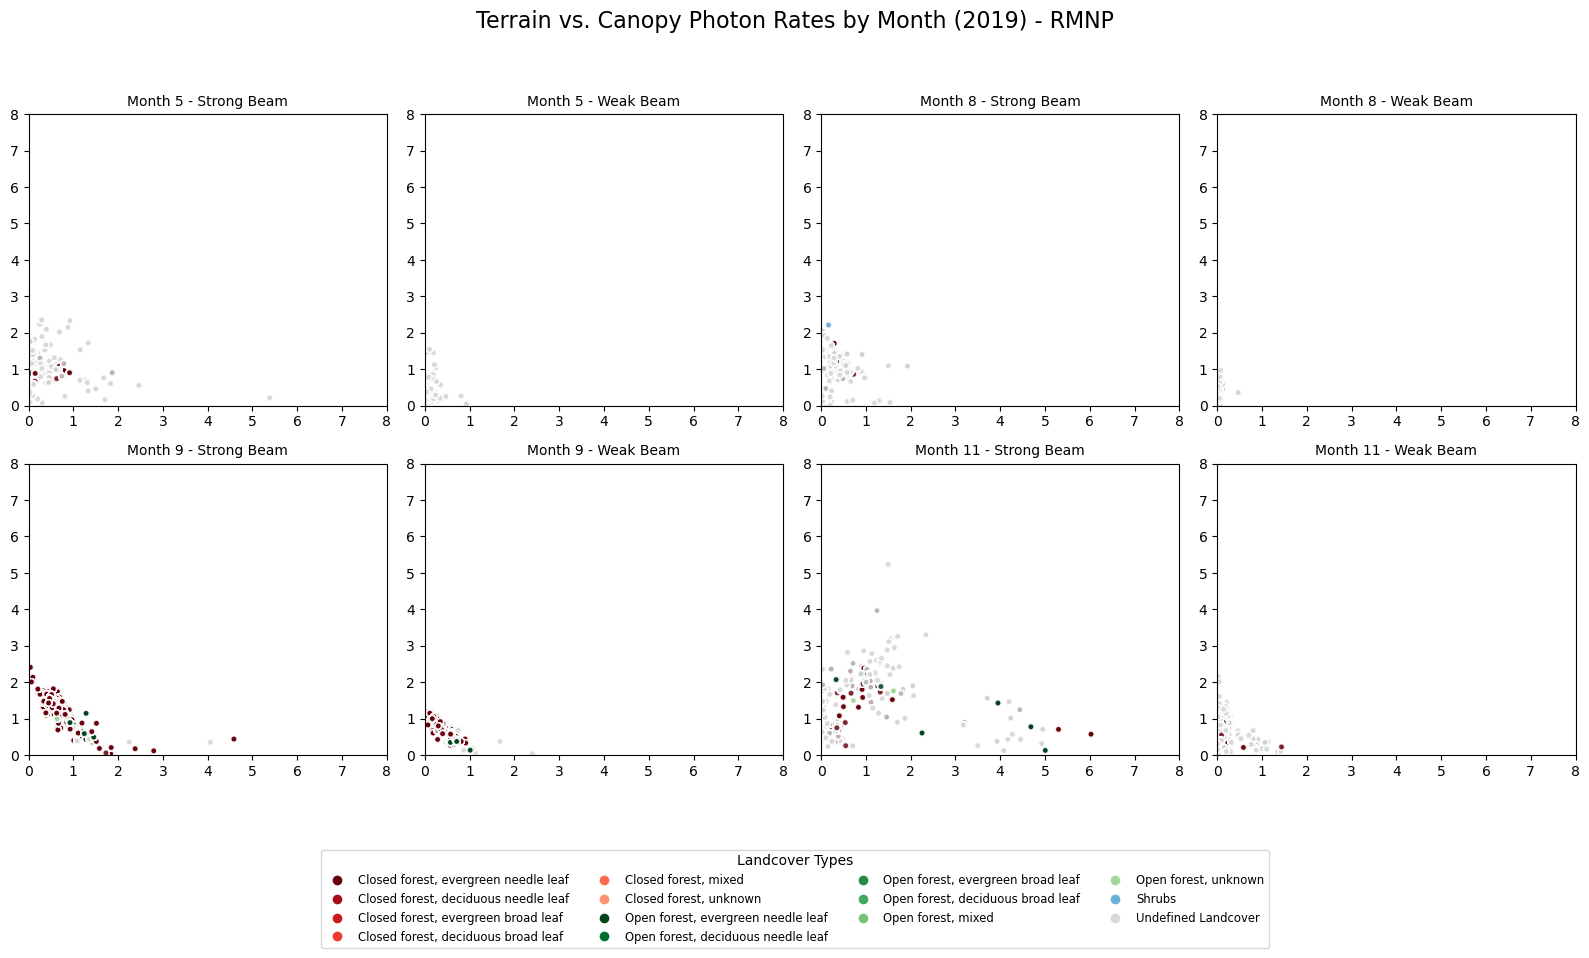

Saved plot to: year/RMNP_terrain_vs_canopy_2019_ats10.png


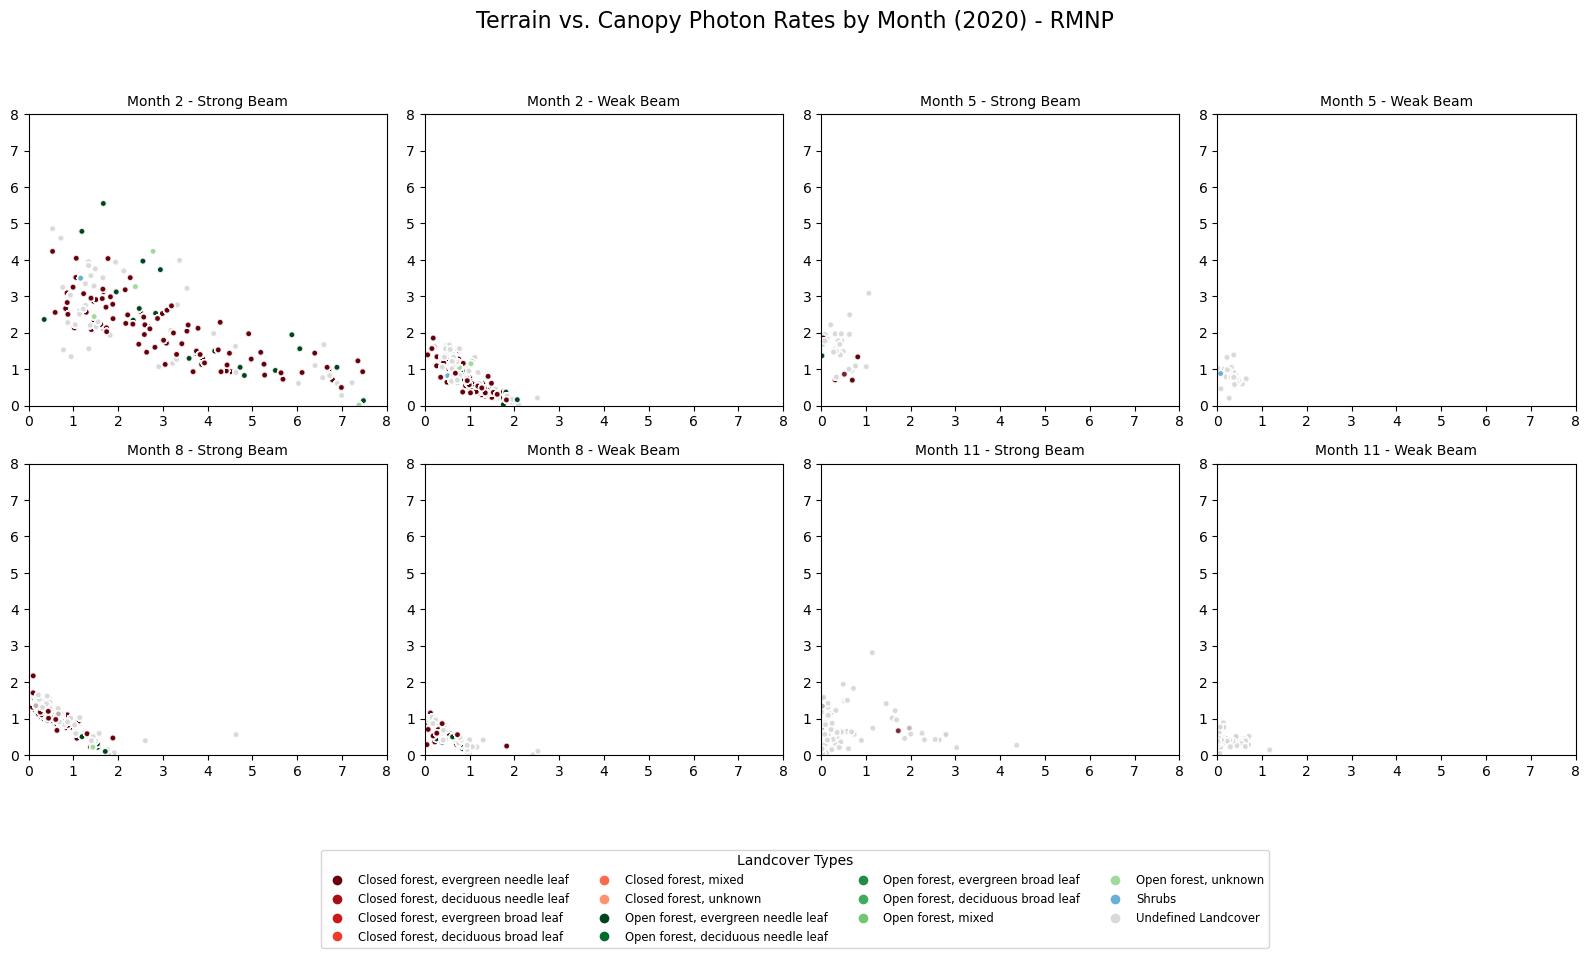

Saved plot to: year/RMNP_terrain_vs_canopy_2020_ats10.png


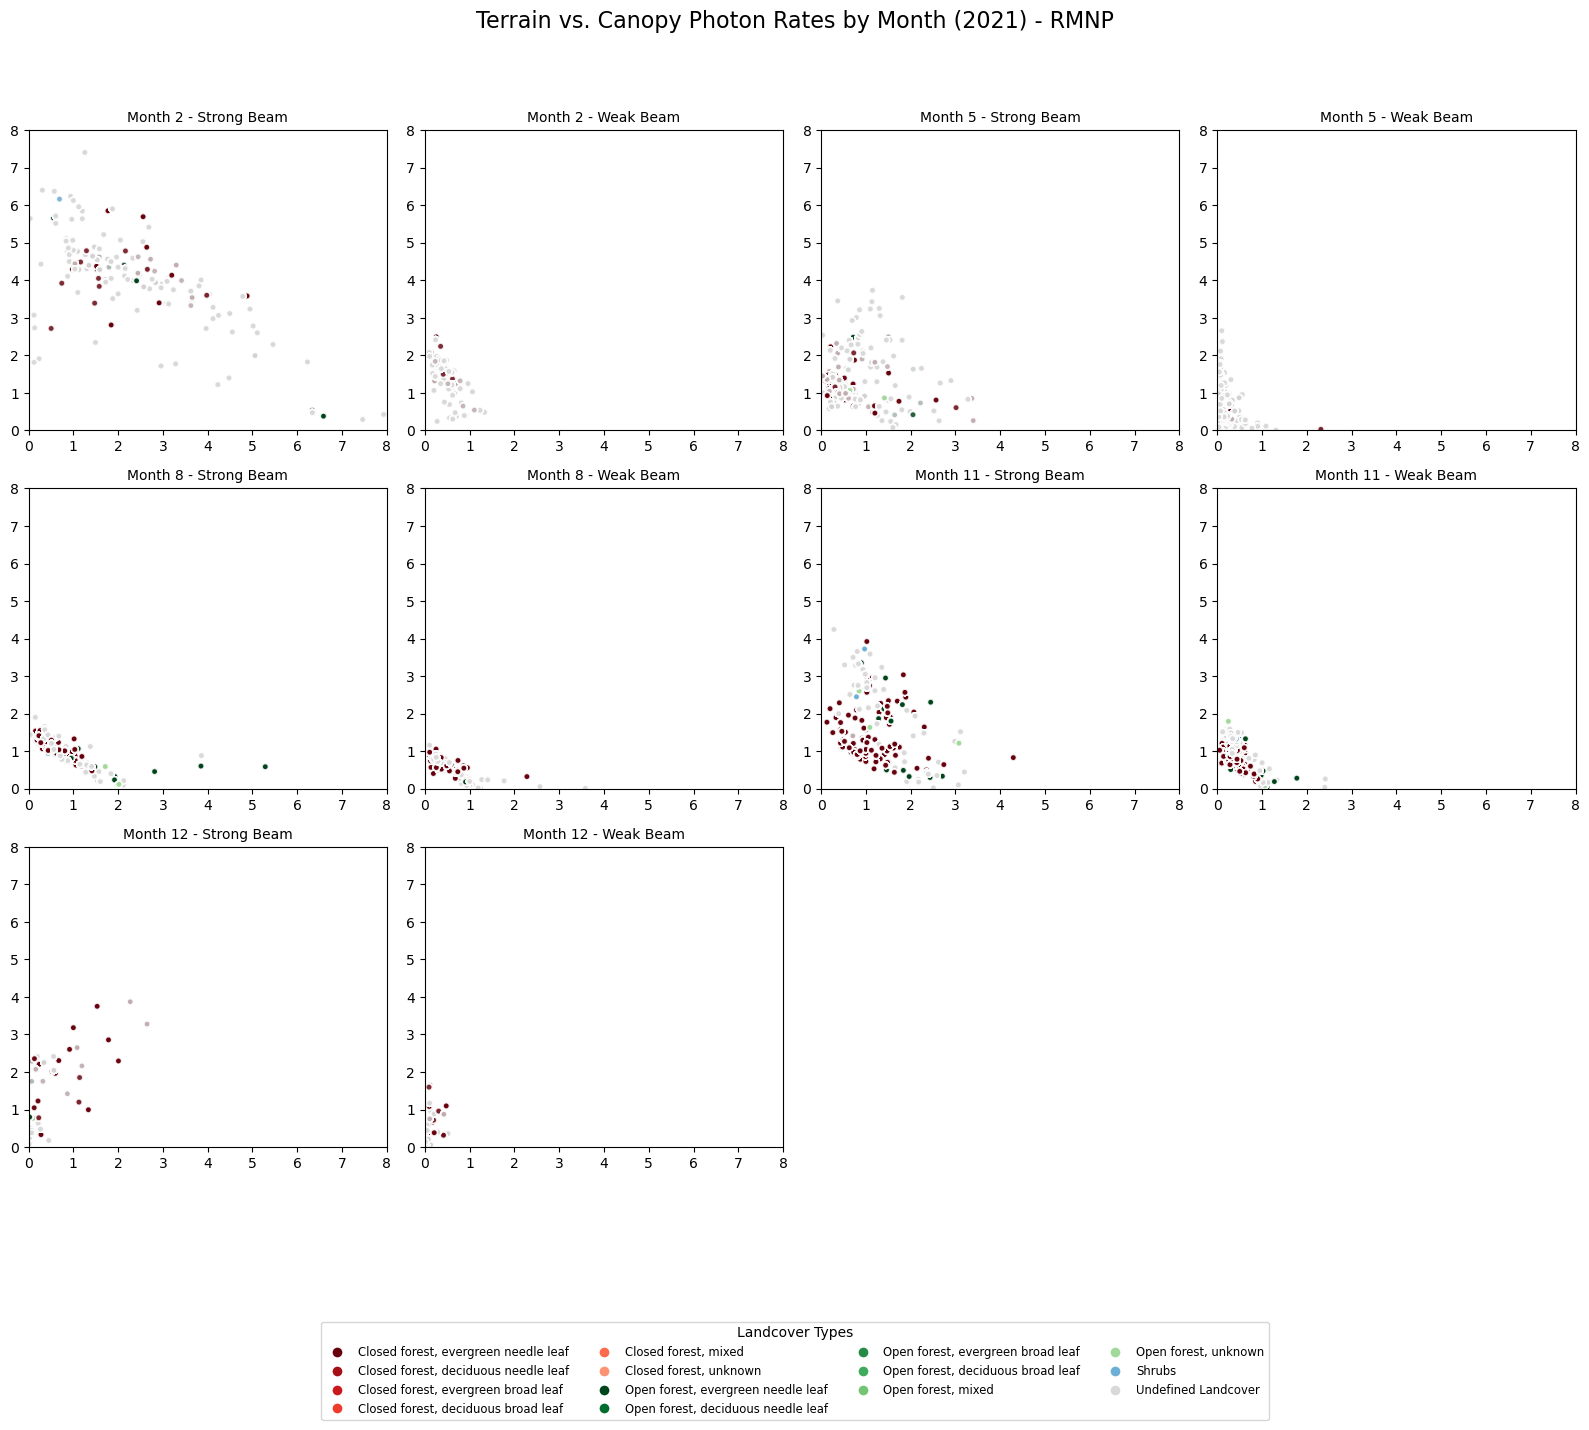

Saved plot to: year/RMNP_terrain_vs_canopy_2021_ats10.png


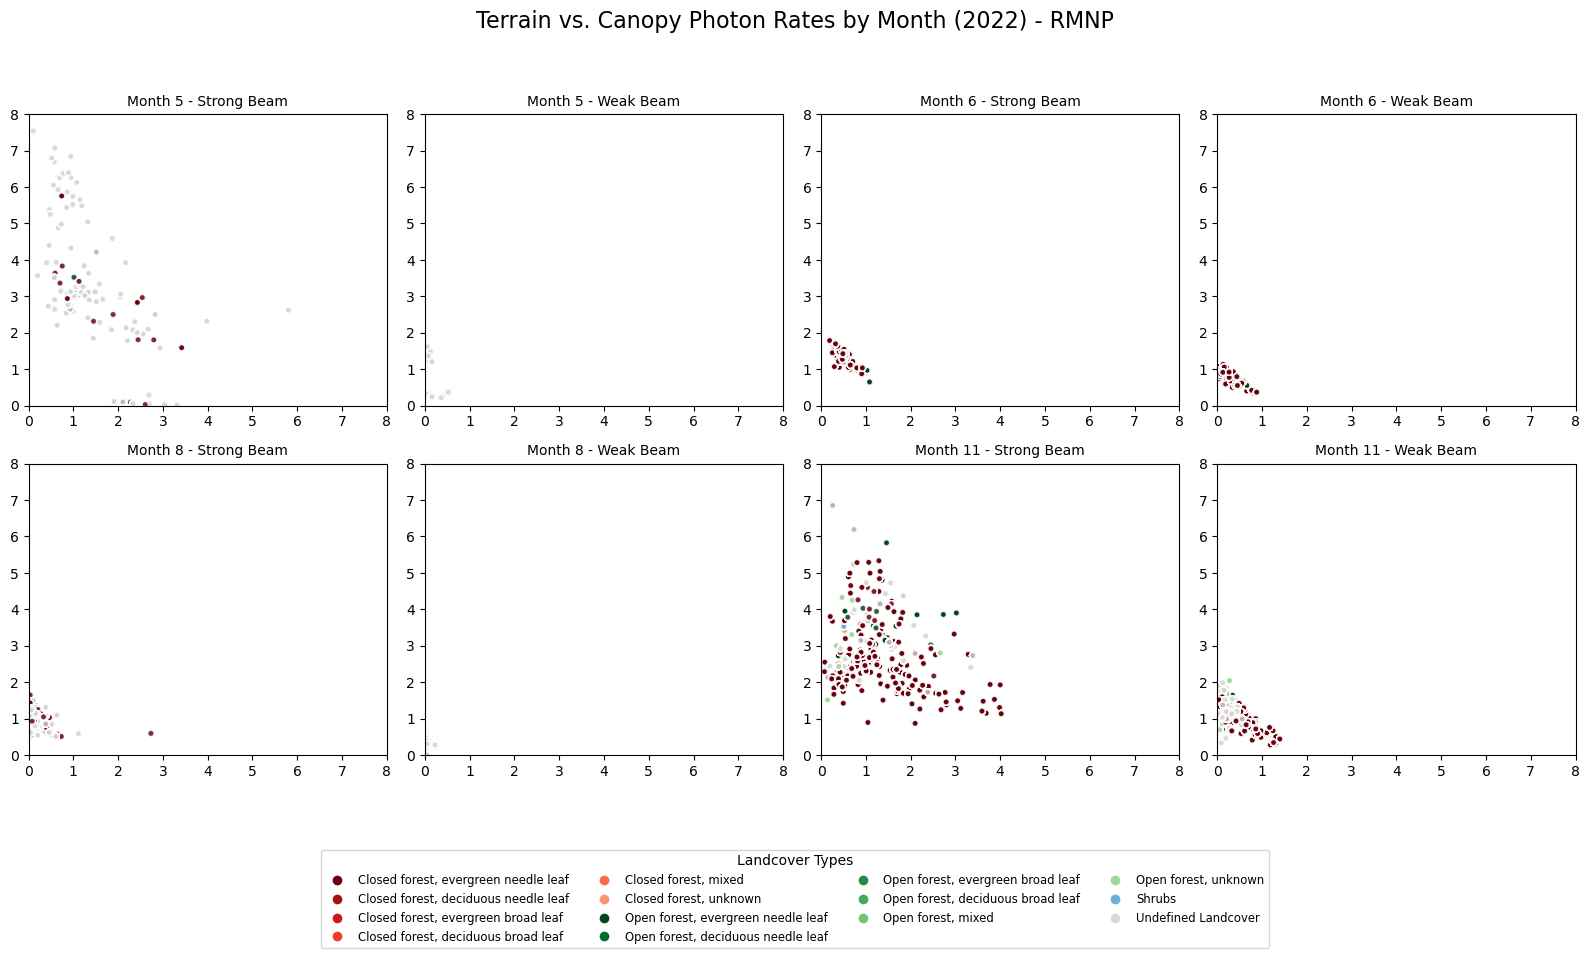

Saved plot to: year/RMNP_terrain_vs_canopy_2022_ats10.png


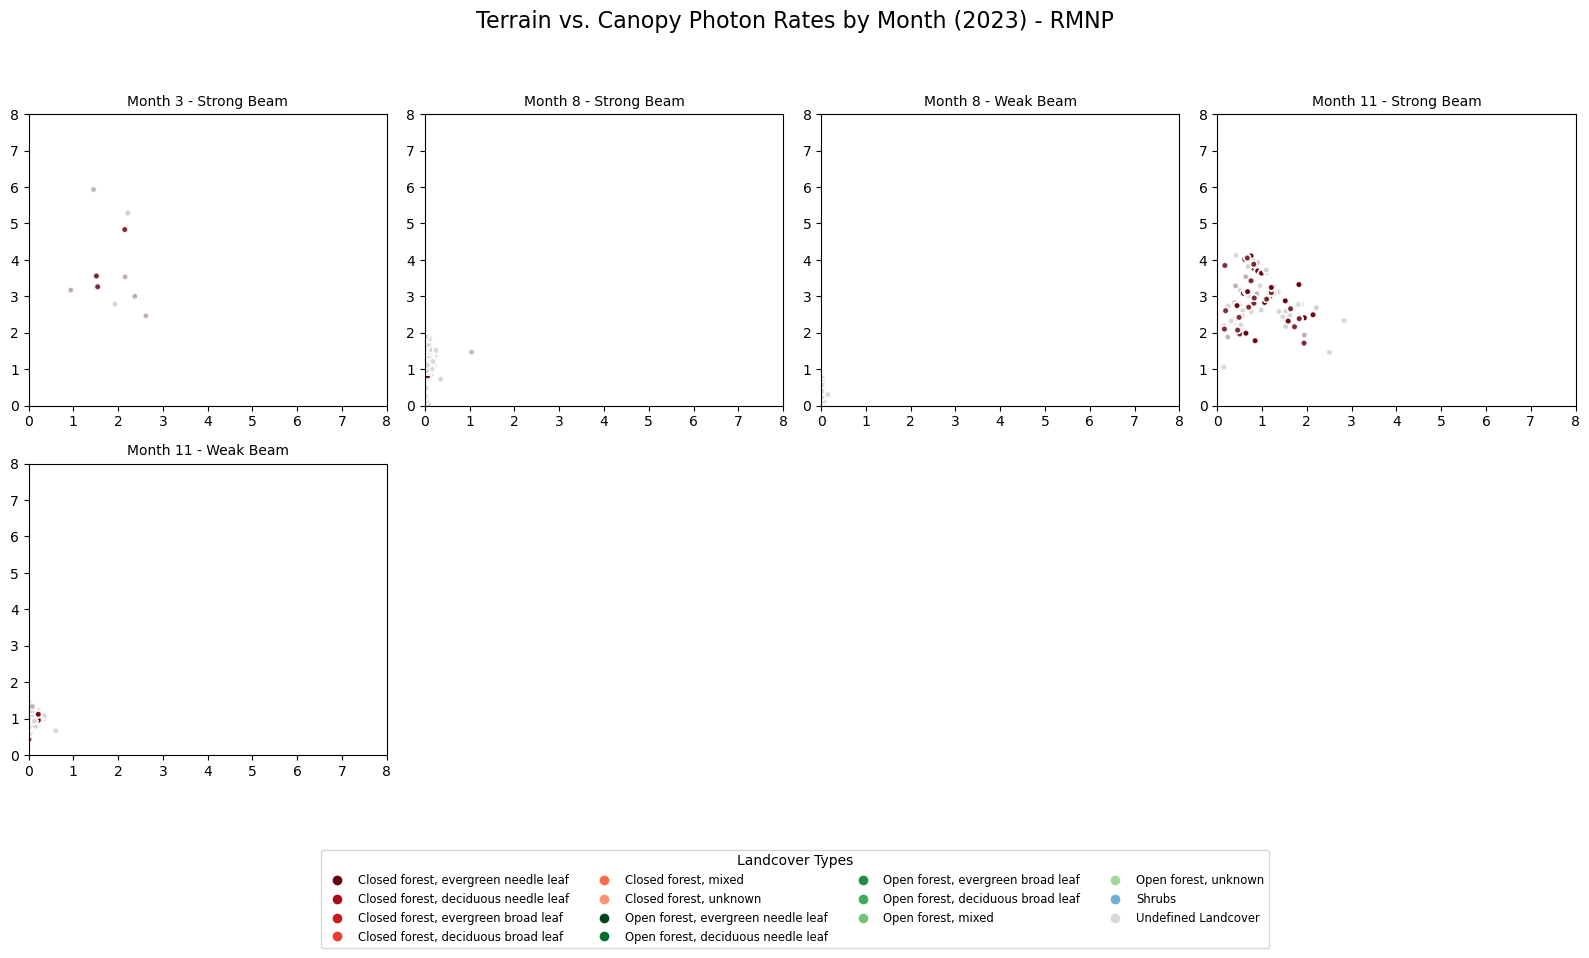

Saved plot to: year/RMNP_terrain_vs_canopy_2023_ats10.png
CPU times: user 3min 48s, sys: 13.7 s, total: 4min 1s
Wall time: 3min 45s


In [13]:
%%time
# Define the landcover color map and descriptions
landcover_colors = {
    111: '#67000d',  # Closed forest, evergreen needle leaf
    113: '#a50f15',  # Closed forest, deciduous needle leaf
    112: '#cb181d',  # Closed forest, evergreen broad leaf
    114: '#ef3b2c',  # Closed forest, deciduous broad leaf
    115: '#fb6a4a',  # Closed forest, mixed
    116: '#fc9272',  # Closed forest, unknown
    121: '#00441b',  # Open forest, evergreen needle leaf
    123: '#006d2c',  # Open forest, deciduous needle leaf
    122: '#238b45',  # Open forest, evergreen broad leaf
    124: '#41ab5d',  # Open forest, deciduous broad leaf
    125: '#74c476',  # Open forest, mixed
    126: '#a1d99b',  # Open forest, unknown
    20: '#6baed6'    # Shrubs
}

landcover_descriptions = {
    111: 'Closed forest, evergreen needle leaf',
    113: 'Closed forest, deciduous needle leaf',
    112: 'Closed forest, evergreen broad leaf',
    114: 'Closed forest, deciduous broad leaf',
    115: 'Closed forest, mixed',
    116: 'Closed forest, unknown',
    121: 'Open forest, evergreen needle leaf',
    123: 'Open forest, deciduous needle leaf',
    122: 'Open forest, evergreen broad leaf',
    124: 'Open forest, deciduous broad leaf',
    125: 'Open forest, mixed',
    126: 'Open forest, unknown',
    20: 'Shrubs'
}

def plot_monthly_beams(data, spots, ax, month):
    """
    Plot strong or weak beam data for a specific month on a given axis.

    Parameters:
        data (pd.DataFrame): DataFrame containing the data to plot.
        spots (list): List of spot values to filter (e.g., [1, 3, 5] for strong beams).
        ax (matplotlib.axes._subplots.AxesSubplot): Axis to plot on.
        month (int): Month to filter data for.
    """
    # Filter the data for the specific spot values and month
    beam_data = data[
        (data['spot'].isin(spots)) &
        (data['month'] == month) &
        data['terrain_photon_rate'].notna() &
        data['canopy_photon_rate'].notna()
    ]

    # Plot if data exists
    if not beam_data.empty:
        ax.scatter(
            beam_data['terrain_photon_rate'],
            beam_data['canopy_photon_rate'],
            c=beam_data['landcover'].map(landcover_colors).fillna('#d9d9d9'),
            alpha=0.8,
            edgecolor='w',
            s=20
        )
        ax.set_title(f"Month {month} - {'Strong' if spots == [1, 3, 5] else 'Weak'} Beam", fontsize=10)
        ax.set_xlim(0, 8)
        ax.set_ylim(0, 8)
    else:
        ax.axis('off')  # Hide the axis if there's no data

def generate_yearly_beam_plots(processed_site_data):
    """
    Create superplots for all years, separating strong and weak beams by month.

    Parameters:
        processed_site_data (dict): Dictionary containing data for each year.
    """
    for year, year_data in processed_site_data.items():
        # Identify months with valid data
        months_with_data_strong = year_data[
            (year_data['spot'].isin([1, 3, 5])) &
            year_data['terrain_photon_rate'].notna() &
            year_data['canopy_photon_rate'].notna()
        ]['month'].unique()

        months_with_data_weak = year_data[
            (year_data['spot'].isin([2, 4, 6])) &
            year_data['terrain_photon_rate'].notna() &
            year_data['canopy_photon_rate'].notna()
        ]['month'].unique()

        # Combine all months with data
        months_with_data = sorted(set(months_with_data_strong).union(set(months_with_data_weak)))

        # Calculate the number of rows required for the subplots
        num_subplots = len(months_with_data) * 2
        ncols = 4
        nrows = -(-num_subplots // ncols)  # Ceiling division

        # Set up the superplot
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
        fig.suptitle(f'Terrain vs. Canopy Photon Rates by Month ({year}) - {site_name}', fontsize=16)
        axes = axes.flatten()

        # Keep track of which axes are used
        ax_index = 0
        for month in months_with_data:
            if ax_index >= len(axes):
                break

            # Plot strong beams
            if month in months_with_data_strong:
                plot_monthly_beams(year_data, [1, 3, 5], axes[ax_index], month)
                ax_index += 1

            # Plot weak beams
            if month in months_with_data_weak and ax_index < len(axes):
                plot_monthly_beams(year_data, [2, 4, 6], axes[ax_index], month)
                ax_index += 1

        # Hide unused axes
        for ax in axes[ax_index:]:
            ax.axis('off')

        # Add a shared legend
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', label=landcover_descriptions[lc],
                       markerfacecolor=color, markersize=8)
            for lc, color in landcover_colors.items()
        ]
        legend_elements.append(
            plt.Line2D([0], [0], marker='o', color='w', label='Undefined Landcover', 
                       markerfacecolor='#d9d9d9', markersize=8)
        )
        fig.legend(
            handles=legend_elements,
            loc='lower center',
            ncol=4,
            fontsize='small',
            title='Landcover Types',
            bbox_to_anchor=(0.5, -0.2)
        )

        # Adjust layout and save
        plt.tight_layout(rect=[0, 0.0, 1, 0.94])  # Leave space for the title and legend
        savefile = os.path.join(folder, f'{site_name}_terrain_vs_canopy_{year}_ats{ats}.png')
        plt.savefig(savefile)
        plt.show()
        print(f"Saved plot to: {savefile}")

generate_yearly_beam_plots(processed_site_data)